# Overview

# Business Understanding

# Data Understanding

## Data Preparation

In [1427]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import matplotlib.patches as mpatches

In [1329]:
conn = sqlite3.Connection('data/im.db')
imdb_df = pd.read_sql("""

SELECT primary_title, runtime_minutes, genres, averagerating, numvotes, start_year
FROM movie_basics
JOIN movie_ratings
USING(movie_id)

;""",conn)
imdb_df.head()

,primary_title,runtime_minutes,genres,averagerating,numvotes,start_year
0,Sunghursh,175.0,"Action,Crime,Drama",7.0,77,2013
1,One Day Before the Rainy Season,114.0,"Biography,Drama",7.2,43,2019
2,The Other Side of the Wind,122.0,Drama,6.9,4517,2018
3,Sabse Bada Sukh,NaN,"Comedy,Drama",6.1,13,2018
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",6.5,119,2017


In [1330]:
imdb_df['primary_title'] = imdb_df['primary_title'].apply(lambda x: x.lower())

In [1331]:
imdb_df.head()

,primary_title,runtime_minutes,genres,averagerating,numvotes,start_year
0,sunghursh,175.0,"Action,Crime,Drama",7.0,77,2013
1,one day before the rainy season,114.0,"Biography,Drama",7.2,43,2019
2,the other side of the wind,122.0,Drama,6.9,4517,2018
3,sabse bada sukh,NaN,"Comedy,Drama",6.1,13,2018
4,the wandering soap opera,80.0,"Comedy,Drama,Fantasy",6.5,119,2017


In [1332]:
tn_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [1333]:
tn_df['movie'] = tn_df['movie'].apply(lambda x: x.lower())

In [1334]:
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",star wars ep. viii: the last jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [1335]:
combined_df = tn_df.merge(imdb_df, left_on='movie', right_on='primary_title', how = 'inner')

In [1336]:
# length of dataframe is longer than length of tn_df that we merged on meaning there are multiple primary_titles
# that match the movie titles. Essentially duplicated names; movies with same name. We need to figure out how to
# make sure we are using the right ones and we can do that by matching start_year with release date_year. This
# will not be perfect as dups can have the same year potentially but it will greatly reduce this number for us. 
# Also, some movies might have the same name but not be referring to the same movie, for example avatar is not a
# horror movie and doing further research you see there is an older movie also called avatar. 
combined_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,runtime_minutes,genres,averagerating,numvotes,start_year
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279",avatar,93.0,Horror,6.1,43,2011
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",6.6,447624,2011
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",dark phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,2019
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,2015
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",8.5,670926,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
2930,62,"Dec 31, 2014",stories of our lives,"$15,000",$0,$0,stories of our lives,60.0,Drama,7.5,85,2014
2931,68,"Jul 6, 2001",cure,"$10,000","$94,596","$94,596",cure,93.0,Drama,4.9,11,2011
2932,73,"Jan 13, 2012",newlyweds,"$9,000","$4,584","$4,584",newlyweds,95.0,"Comedy,Drama",6.4,1436,2011
2933,78,"Dec 31, 2018",red 11,"$7,000",$0,$0,red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,2019


In [1337]:
combined_df['matching_year'] = combined_df['release_date'].apply(lambda x: x[-4:]).astype(float)

In [1338]:
combined_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,runtime_minutes,genres,averagerating,numvotes,start_year,matching_year
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279",avatar,93.0,Horror,6.1,43,2011,2009.0
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",6.6,447624,2011,2011.0
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",dark phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,2019,2019.0
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,2015,2015.0
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",8.5,670926,2018,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2930,62,"Dec 31, 2014",stories of our lives,"$15,000",$0,$0,stories of our lives,60.0,Drama,7.5,85,2014,2014.0
2931,68,"Jul 6, 2001",cure,"$10,000","$94,596","$94,596",cure,93.0,Drama,4.9,11,2011,2001.0
2932,73,"Jan 13, 2012",newlyweds,"$9,000","$4,584","$4,584",newlyweds,95.0,"Comedy,Drama",6.4,1436,2011,2012.0
2933,78,"Dec 31, 2018",red 11,"$7,000",$0,$0,red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,2019,2018.0


In [1339]:
combined_df = combined_df[(combined_df['start_year'] == combined_df['matching_year'])]

In [1340]:
combined_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,runtime_minutes,genres,averagerating,numvotes,start_year,matching_year
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",6.6,447624,2011,2011.0
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",dark phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,2019,2019.0
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,2015,2015.0
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",8.5,670926,2018,2018.0
5,9,"Nov 17, 2017",justice league,"$300,000,000","$229,024,295","$655,945,209",justice league,120.0,"Action,Adventure,Fantasy",6.5,329135,2017,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,45,"Jan 27, 2017",emily,"$27,000","$3,547","$3,547",emily,83.0,Drama,6.8,13,2017,2017.0
2921,49,"Sep 1, 2015",exeter,"$25,000",$0,"$489,792",exeter,91.0,"Horror,Mystery,Thriller",4.5,5156,2015,2015.0
2926,52,"Dec 1, 2015",dutch kills,"$25,000",$0,$0,dutch kills,90.0,"Crime,Drama,Thriller",5.1,82,2015,2015.0
2929,59,"Nov 25, 2011",the ridges,"$17,300",$0,$0,the ridges,89.0,"Drama,Horror,Thriller",2.9,127,2011,2011.0


In [1341]:
#Will be removing other columns as we progress; create drop function for reusability
def drop(cols,df):
    '''Is going to take the column name and apply the drop function'''
    for x in cols:
        df.drop(columns=x, inplace=True)

In [1342]:
drop(['id','primary_title', 'start_year', 'matching_year'], combined_df)


<ipython-input-1341-9bb459816f07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=x, inplace=True)
<ipython-input-1341-9bb459816f07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=x, inplace=True)
<ipython-input-1341-9bb459816f07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=x, inplace=True)
<ipython-input-1341-9bb459816f07>:5: SettingWithCopyWarning: 
A value is trying to be set o

In [1343]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 1 to 2930
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1541 non-null   object 
 1   movie              1541 non-null   object 
 2   production_budget  1541 non-null   object 
 3   domestic_gross     1541 non-null   object 
 4   worldwide_gross    1541 non-null   object 
 5   runtime_minutes    1533 non-null   float64
 6   genres             1539 non-null   object 
 7   averagerating      1541 non-null   float64
 8   numvotes           1541 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 120.4+ KB


In [1344]:
def money_values(lst):
    for df in lst:
        combined_df[df] = combined_df[df].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        combined_df[df] = combined_df[df].apply(int)

In [1345]:
monetary_columns_lst = ['production_budget', 'domestic_gross', 'worldwide_gross']

In [1346]:
money_values(monetary_columns_lst)

<ipython-input-1344-61a1735999f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[df] = combined_df[df].apply(lambda x: re.sub(r'[^\w\s]', '', x))
<ipython-input-1344-61a1735999f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[df] = combined_df[df].apply(int)
<ipython-input-1344-61a1735999f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [1347]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 1 to 2930
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1541 non-null   object 
 1   movie              1541 non-null   object 
 2   production_budget  1541 non-null   int64  
 3   domestic_gross     1541 non-null   int64  
 4   worldwide_gross    1541 non-null   int64  
 5   runtime_minutes    1533 non-null   float64
 6   genres             1539 non-null   object 
 7   averagerating      1541 non-null   float64
 8   numvotes           1541 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 120.4+ KB


In [1348]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 1 to 2930
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1541 non-null   object 
 1   movie              1541 non-null   object 
 2   production_budget  1541 non-null   int64  
 3   domestic_gross     1541 non-null   int64  
 4   worldwide_gross    1541 non-null   int64  
 5   runtime_minutes    1533 non-null   float64
 6   genres             1539 non-null   object 
 7   averagerating      1541 non-null   float64
 8   numvotes           1541 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 120.4+ KB


In [1349]:
combined_df['runtime_minutes'].agg(['mean','median'])

mean      107.378343
median    105.000000
Name: runtime_minutes, dtype: float64

array([[<Axes: title={'center': 'runtime_minutes'}>]], dtype=object)

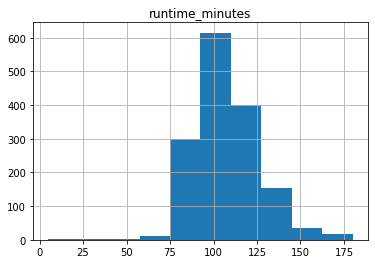

In [1350]:
combined_df.hist('runtime_minutes')

In [1351]:
combined_df['runtime_minutes'] = combined_df['runtime_minutes'].fillna(combined_df['runtime_minutes'].mean())

<ipython-input-1351-f6311877dede>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['runtime_minutes'] = combined_df['runtime_minutes'].fillna(combined_df['runtime_minutes'].mean())


In [1352]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 1 to 2930
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1541 non-null   object 
 1   movie              1541 non-null   object 
 2   production_budget  1541 non-null   int64  
 3   domestic_gross     1541 non-null   int64  
 4   worldwide_gross    1541 non-null   int64  
 5   runtime_minutes    1541 non-null   float64
 6   genres             1539 non-null   object 
 7   averagerating      1541 non-null   float64
 8   numvotes           1541 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 120.4+ KB


In [1353]:
combined_df.reset_index(drop=True, inplace=True)

In [1354]:
combined_df[combined_df['genres'].isna()]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,runtime_minutes,genres,averagerating,numvotes
28,"Nov 21, 2018",robin hood,99000000,30824628,84747441,107.378343,None,7.6,5
454,"Mar 19, 2010",the bounty hunter,45000000,67061228,135808837,107.378343,None,6.3,29


In [1355]:
combined_df.loc[28,'genres'] = 'Action,Adventure'

In [1356]:
combined_df.loc[454,'genres'] = 'Comedy,Action'

In [1357]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1541 non-null   object 
 1   movie              1541 non-null   object 
 2   production_budget  1541 non-null   int64  
 3   domestic_gross     1541 non-null   int64  
 4   worldwide_gross    1541 non-null   int64  
 5   runtime_minutes    1541 non-null   float64
 6   genres             1541 non-null   object 
 7   averagerating      1541 non-null   float64
 8   numvotes           1541 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 108.5+ KB


In [1358]:
combined_df['release_date'].value_counts()

release_date
Dec 31, 2014    14
Dec 31, 2015    10
Sep 23, 2011     9
Dec 31, 2012     8
Oct 10, 2014     8
                ..
Jun 12, 2013     1
Apr 20, 2018     1
Apr 12, 2013     1
Jul 29, 2015     1
Jan 27, 2017     1
Name: count, Length: 611, dtype: int64

In [1359]:
combined_df['movie'].value_counts()

movie
robin hood              3
redemption              3
brothers                3
highway                 2
let there be light      2
                       ..
paul                    1
scream 4                1
sex tape                1
widows                  1
stories of our lives    1
Name: count, Length: 1504, dtype: int64

In [1360]:
combined_df['genres'].value_counts()

genres
Adventure,Animation,Comedy    69
Drama                         60
Comedy                        57
Action,Adventure,Sci-Fi       53
Comedy,Drama,Romance          52
                              ..
Adventure,Drama,Western        1
Comedy,Sci-Fi                  1
Comedy,Drama,Sport             1
Adventure,Comedy,Sci-Fi        1
Biography,Documentary          1
Name: count, Length: 232, dtype: int64

In [1361]:
combined_df['production_budget'].value_counts()

production_budget
20000000     68
10000000     62
30000000     50
40000000     50
5000000      48
             ..
350000000     1
24200000      1
22500000      1
21500000      1
15000         1
Name: count, Length: 258, dtype: int64

In [1362]:
combined_df['domestic_gross'].value_counts()

domestic_gross
0           161
656688        3
36686         3
4073448       2
26594261      2
           ... 
13414714      1
15541549      1
19894664      1
44922302      1
3547          1
Name: count, Length: 1348, dtype: int64

In [1363]:
combined_df['worldwide_gross'].value_counts()

worldwide_gross
0           108
13593473      3
17856688      3
92088460      2
84747441      2
           ... 
49621440      1
36197221      1
41926605      1
91678442      1
489792        1
Name: count, Length: 1400, dtype: int64

In [1364]:
combined_df['runtime_minutes'].describe()

count    1541.000000
mean      107.378343
std        18.012055
min         5.000000
25%        94.000000
50%       105.000000
75%       117.000000
max       180.000000
Name: runtime_minutes, dtype: float64

In [1365]:
combined_df['averagerating'].value_counts()

averagerating
6.6    77
6.3    77
6.5    69
6.2    69
6.4    64
       ..
2.6     1
8.6     1
1.9     1
2.5     1
2.1     1
Name: count, Length: 66, dtype: int64

In [1366]:
combined_df['numvotes'].value_counts()

numvotes
5         4
25        3
6         2
12        2
127       2
         ..
118779    1
100520    1
61615     1
98061     1
85        1
Name: count, Length: 1521, dtype: int64

In [1367]:
combined_df = combined_df[combined_df['runtime_minutes']>30]

In [1368]:
combined_df = combined_df[combined_df['numvotes']>=30]

In [1369]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516 entries, 0 to 1540
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1516 non-null   object 
 1   movie              1516 non-null   object 
 2   production_budget  1516 non-null   int64  
 3   domestic_gross     1516 non-null   int64  
 4   worldwide_gross    1516 non-null   int64  
 5   runtime_minutes    1516 non-null   float64
 6   genres             1516 non-null   object 
 7   averagerating      1516 non-null   float64
 8   numvotes           1516 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 118.4+ KB


In [1370]:
drop(['runtime_minutes','numvotes', 'domestic_gross'], combined_df)

In [1371]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516 entries, 0 to 1540
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1516 non-null   object 
 1   movie              1516 non-null   object 
 2   production_budget  1516 non-null   int64  
 3   worldwide_gross    1516 non-null   int64  
 4   genres             1516 non-null   object 
 5   averagerating      1516 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 82.9+ KB


In [1372]:
combined_df['season'] = combined_df['release_date'].apply(lambda x: x[:3])

In [1373]:
combined_df['season'].value_counts()

season
Dec    190
Oct    166
Nov    147
Sep    146
Aug    129
Jul    128
Mar    123
Jun    120
May    106
Feb     98
Apr     95
Jan     68
Name: count, dtype: int64

In [1374]:
season_dict = {'Jan':'Winter','Feb':'Winter','Dec':'Winter','Jun':'Summer','Jul':'Summer','Aug':'Summer',
               'Sep':'Fall','Oct':'Fall','Nov':'Fall','Mar':'Spring','Apr':'Spring','May':'Spring'}

In [1375]:
combined_df['season'] = combined_df['season'].apply(lambda x: season_dict[x])

In [1376]:
combined_df

,release_date,movie,production_budget,worldwide_gross,genres,averagerating,season
0,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000,1045663875,"Action,Adventure,Fantasy",6.6,Spring
1,"Jun 7, 2019",dark phoenix,350000000,149762350,"Action,Adventure,Sci-Fi",6.0,Summer
2,"May 1, 2015",avengers: age of ultron,330600000,1403013963,"Action,Adventure,Sci-Fi",7.3,Spring
3,"Apr 27, 2018",avengers: infinity war,300000000,2048134200,"Action,Adventure,Sci-Fi",8.5,Spring
4,"Nov 17, 2017",justice league,300000000,655945209,"Action,Adventure,Fantasy",6.5,Fall
...,...,...,...,...,...,...,...
1535,"Oct 25, 2013",her cry: la llorona investigation,35000,0,Horror,3.7,Fall
1537,"Sep 1, 2015",exeter,25000,489792,"Horror,Mystery,Thriller",4.5,Fall
1538,"Dec 1, 2015",dutch kills,25000,0,"Crime,Drama,Thriller",5.1,Winter
1539,"Nov 25, 2011",the ridges,17300,0,"Drama,Horror,Thriller",2.9,Fall


In [1377]:
drop(['release_date'],combined_df)

In [1378]:
combined_df

,movie,production_budget,worldwide_gross,genres,averagerating,season
0,pirates of the caribbean: on stranger tides,410600000,1045663875,"Action,Adventure,Fantasy",6.6,Spring
1,dark phoenix,350000000,149762350,"Action,Adventure,Sci-Fi",6.0,Summer
2,avengers: age of ultron,330600000,1403013963,"Action,Adventure,Sci-Fi",7.3,Spring
3,avengers: infinity war,300000000,2048134200,"Action,Adventure,Sci-Fi",8.5,Spring
4,justice league,300000000,655945209,"Action,Adventure,Fantasy",6.5,Fall
...,...,...,...,...,...,...
1535,her cry: la llorona investigation,35000,0,Horror,3.7,Fall
1537,exeter,25000,489792,"Horror,Mystery,Thriller",4.5,Fall
1538,dutch kills,25000,0,"Crime,Drama,Thriller",5.1,Winter
1539,the ridges,17300,0,"Drama,Horror,Thriller",2.9,Fall


In [1379]:
combined_df['production_budget'].describe()

count    1.516000e+03
mean     4.476091e+07
std      5.599334e+07
min      1.500000e+04
25%      8.000000e+06
50%      2.400000e+07
75%      5.500000e+07
max      4.106000e+08
Name: production_budget, dtype: float64

In [1380]:
bins = [14999, 82132000, 164249000, 246366000, 328483000, 410600000]

combined_df['production_budget'] = pd.cut(combined_df['production_budget'], bins)

In [1381]:
combined_df

,movie,production_budget,worldwide_gross,genres,averagerating,season
0,pirates of the caribbean: on stranger tides,"(328483000, 410600000]",1045663875,"Action,Adventure,Fantasy",6.6,Spring
1,dark phoenix,"(328483000, 410600000]",149762350,"Action,Adventure,Sci-Fi",6.0,Summer
2,avengers: age of ultron,"(328483000, 410600000]",1403013963,"Action,Adventure,Sci-Fi",7.3,Spring
3,avengers: infinity war,"(246366000, 328483000]",2048134200,"Action,Adventure,Sci-Fi",8.5,Spring
4,justice league,"(246366000, 328483000]",655945209,"Action,Adventure,Fantasy",6.5,Fall
...,...,...,...,...,...,...
1535,her cry: la llorona investigation,"(14999, 82132000]",0,Horror,3.7,Fall
1537,exeter,"(14999, 82132000]",489792,"Horror,Mystery,Thriller",4.5,Fall
1538,dutch kills,"(14999, 82132000]",0,"Crime,Drama,Thriller",5.1,Winter
1539,the ridges,"(14999, 82132000]",0,"Drama,Horror,Thriller",2.9,Fall


In [1382]:
combined_df['genres'].value_counts()

genres
Adventure,Animation,Comedy    69
Comedy                        57
Drama                         55
Action,Adventure,Sci-Fi       53
Comedy,Drama,Romance          52
                              ..
Action,Fantasy,War             1
Biography,Drama,Mystery        1
Sci-Fi,Thriller                1
Fantasy                        1
Biography,Documentary          1
Name: count, Length: 229, dtype: int64

In [1383]:
genre_df = combined_df[['worldwide_gross', 'genres']]

In [1384]:
genre_df

,worldwide_gross,genres
0,1045663875,"Action,Adventure,Fantasy"
1,149762350,"Action,Adventure,Sci-Fi"
2,1403013963,"Action,Adventure,Sci-Fi"
3,2048134200,"Action,Adventure,Sci-Fi"
4,655945209,"Action,Adventure,Fantasy"
...,...,...
1535,0,Horror
1537,489792,"Horror,Mystery,Thriller"
1538,0,"Crime,Drama,Thriller"
1539,0,"Drama,Horror,Thriller"


In [1385]:
# https://datascience.stackexchange.com/questions/74277/extract-seperated-value-from-columns

genre_df = genre_df.assign(genre1 = genre_df.genres.str.split(",", expand = True).iloc[:,:1],
                           genre2 = genre_df.genres.str.split(",", expand = True).iloc[:,1:2],
                           genre3 = genre_df.genres.str.split(",", expand = True).iloc[:,2:3])

In [1386]:
drop(['genres'],genre_df)

In [1387]:
lst_1 = list(genre_df['genre1'].unique())

In [1388]:
lst_2 = list(genre_df['genre2'].unique())

In [1389]:
lst_3 = list(genre_df['genre3'].unique())

In [1390]:
lst_1.extend(lst_2)
lst_1.extend(lst_3)

In [1391]:
genre_unique_lst = list(set(lst_1))

In [1392]:
genre_unique_lst

['Western',
 'Fantasy',
 'History',
 'Biography',
 'Animation',
 'Thriller',
 'Musical',
 None,
 'Adventure',
 'Family',
 'Documentary',
 'War',
 'Sci-Fi',
 'Sport',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Action',
 'Comedy',
 'Drama',
 'Crime']

In [1393]:
genre_dict = dict([(x,0) for x in genre_unique_lst])

In [1394]:
genre_dict

{'Western': 0,
 'Fantasy': 0,
 'History': 0,
 'Biography': 0,
 'Animation': 0,
 'Thriller': 0,
 'Musical': 0,
 None: 0,
 'Adventure': 0,
 'Family': 0,
 'Documentary': 0,
 'War': 0,
 'Sci-Fi': 0,
 'Sport': 0,
 'Horror': 0,
 'Music': 0,
 'Mystery': 0,
 'Romance': 0,
 'Action': 0,
 'Comedy': 0,
 'Drama': 0,
 'Crime': 0}

In [1395]:
genre_df

,worldwide_gross,genre1,genre2,genre3
0,1045663875,Action,Adventure,Fantasy
1,149762350,Action,Adventure,Sci-Fi
2,1403013963,Action,Adventure,Sci-Fi
3,2048134200,Action,Adventure,Sci-Fi
4,655945209,Action,Adventure,Fantasy
...,...,...,...,...
1535,0,Horror,None,None
1537,489792,Horror,Mystery,Thriller
1538,0,Crime,Drama,Thriller
1539,0,Drama,Horror,Thriller


In [1396]:
for i in genre_df.index:
    genre_dict[genre_df['genre1'][i]] += genre_df['worldwide_gross'][i]
    genre_dict[genre_df['genre2'][i]] += genre_df['worldwide_gross'][i]
    genre_dict[genre_df['genre3'][i]] += genre_df['worldwide_gross'][i]

In [1399]:
del genre_dict[None]

In [1400]:
genre_dict

{'Western': 1237986930,
 'Fantasy': 29470550564,
 'History': 3425426210,
 'Biography': 10945969415,
 'Animation': 38938423745,
 'Thriller': 29874224730,
 'Musical': 1848993929,
 'Adventure': 124418626319,
 'Family': 18257668444,
 'Documentary': 569782036,
 'War': 982800439,
 'Sci-Fi': 46161508510,
 'Sport': 1751692678,
 'Horror': 12999715047,
 'Music': 4163914830,
 'Mystery': 11395934700,
 'Romance': 13536140958,
 'Action': 108285467135,
 'Comedy': 70525473874,
 'Drama': 53466534124,
 'Crime': 19077308101}

In [1404]:
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse=True))

In [1411]:
top_5_genre = dict(list(genre_dict.items())[:5])

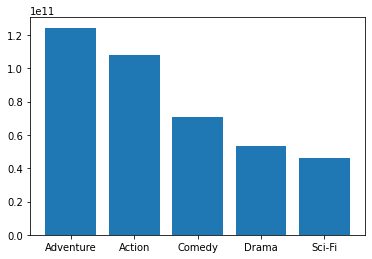

In [1412]:
plt.bar(*zip(*top_5_genre.items()))
plt.show()

In [1423]:
season_gross = combined_df.groupby('season')[['worldwide_gross']].sum().sort_values(by='worldwide_gross',ascending=False)

In [1424]:
season_gross = season_gross.reset_index()

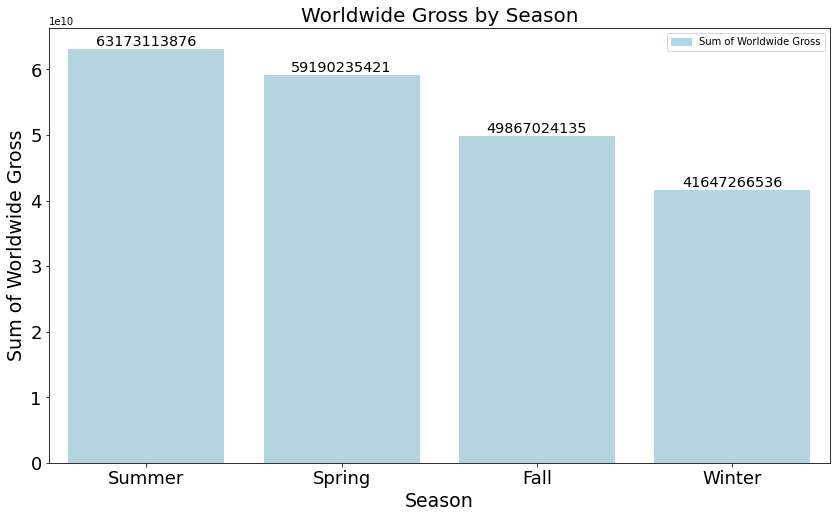

In [1428]:
plt.figure(figsize=(14, 8))

ax1 = sns.barplot(x="season",  y='worldwide_gross', data=season_gross, color='lightblue')


# add legend
bar = mpatches.Patch(color='lightblue', label='Sum of Worldwide Gross')
plt.legend(handles=[bar])

for index, row in season_gross.iterrows():
    ax1.text(row.name, row['worldwide_gross'], row['worldwide_gross'], color='black', ha="center",
             fontsize='x-large',va='bottom')

# show the graph
plt.title('Worldwide Gross by Season',fontsize=20)
plt.xlabel('Season',fontsize=19)
plt.ylabel('Sum of Worldwide Gross',fontsize=19)
plt.tick_params(axis='x',labelsize=18)
plt.tick_params(axis='y',labelsize=18)
plt.show()


#Used stackoverflow example to see how to do the labeling on the bar graph as well as the legend.
#(https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
#(https://stackoverflow.com/questions/65272126/seaborn-how-to-add-legend-to-seaborn-barplot)

In [1437]:
budget_rating = combined_df.groupby('production_budget')[['averagerating']].mean().sort_values(by='averagerating',ascending=False)

In [1438]:
budget_rating = budget_rating.reset_index()

In [1446]:
budget_rating['production_budget'] = budget_rating['production_budget'].astype(str)

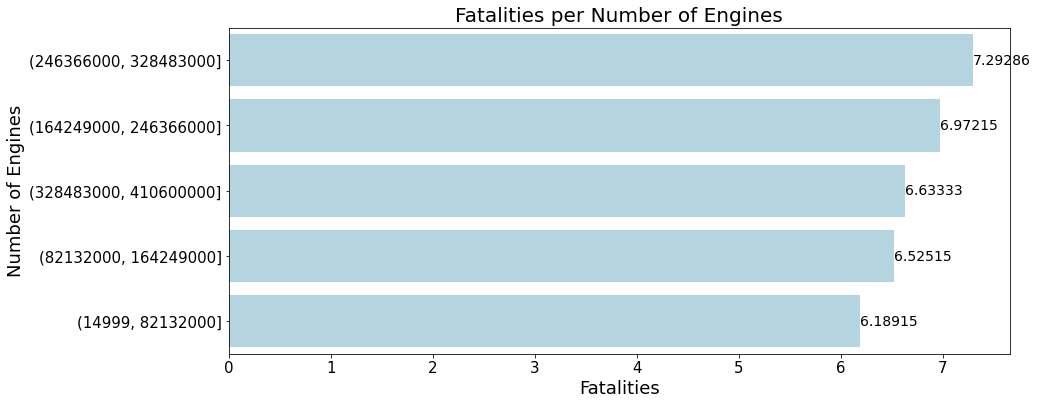

In [1447]:
plt.figure(figsize=(14, 6))

ax1 = sns.barplot(x="averagerating",  y='production_budget', data=budget_rating, color='lightblue')

ax1.bar_label(ax1.containers[0],size=14)
# show the graph

plt.title('Fatalities per Number of Engines',fontsize=20)
plt.xlabel('Fatalities',fontsize=18)
plt.ylabel('Number of Engines',fontsize=18)
plt.tick_params(axis='y',labelsize=15)
plt.tick_params(axis='x',labelsize=15)
plt.show()

#Another way to do bar label that i learned about on stackoverflow.
#(https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn)

# Exploratory Analysis

# Conclusions

## Limitations

## Recommendations

## Next Steps